# Drone Radiation Pattern

In [1]:
import pandas as pd
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import struct

In [2]:
def plot_rss(data: pd.DataFrame, time_window = None, color: str = None):
    plt.figure(figsize=(50, 5))
    if (color is not None):
        plt.plot(data['time'], data['rss'], color)
    else:
        plt.plot(data['time'], data['rss'])
    plt.title('RSS of Drone')
    plt.xlabel('Time (s)')
    if (time_window is not None):
        plt.xlim(time_window)
    plt.ylabel('RSS (dB)')
    plt.grid(True)
    plt.show()

In [3]:
def read_binary_iq_samples(filename: str):
    i_values = []
    q_values = []

    with open(filename, 'rb') as file:
        while True:
            # Read 4 bytes (32 bits) from the file
            i = file.read(4)
            if not i:
                break

            q = file.read(4)
            if not 1:
                break

            # Unpack the binary data into a single float
            i = struct.unpack('f', i)[0]
            q = struct.unpack('f', q)[0]

            i_values.append(i)
            q_values.append(q)

    return pd.DataFrame({'i': i_values, 'q': q_values})

In [4]:
def fill_iq_with_rss(samples: pd.DataFrame, time_window: float = None, noise_floor: float = None):
    if (time_window is not None):
        samples['time'] = (samples.index / len(samples)) * 10

    samples['rss'] = samples['i']**2 + samples['q']**2
    samples = samples[samples['rss'] != 0]
    samples.loc[:, 'rss'] = 10*np.log10(samples['rss']) #RSS
    
    samples = samples.replace([np.inf, -np.inf], np.nan)
    samples = samples.dropna(axis = 0, inplace=False)

    samples = samples[samples['rss'] != 0]

    if (noise_floor is not None):
        samples = samples[samples['rss'] >= noise_floor]
    
    return samples


In [5]:
def extract_packets(samples: pd.DataFrame, noise_floor, window: int = 10000):
    samples['rolling_rss'] = samples['rss'].rolling(window=window).median()
    samples = samples[samples['rolling_rss'] >= noise_floor]

In [30]:
def create_radiation_pattern(ax, data_dict, scale=1, y_limit=None, title=None):
    data_dict = dict(sorted(data_dict.items()))

    #  Extracting the index and value from the dictionary
    indices = list(data_dict.keys())
    values = list(data_dict.values())

    print(len(indices), len(values))

    # Scaling the values
    values = [value * scale for value in values]

    # Converting the indices to radians
    angles = np.radians(indices)

    # Adding the first angle at the end to close the plot
    angles = np.append(angles, angles[0])

    # Adding the first value at the end to close the plot
    values = np.append(values, values[0])

    # Creating the round plot
    ax.plot(angles, values, marker='o')

    ax.set_title(title)

    # Setting the labels for each angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(indices)

    # Limiting the y-values if specified
    if y_limit is not None:
        ax.set_ylim(y_limit)

# Some Constants

In [6]:
time_window = 10

# Background Noise

First we need to get the avarage signal strength of the room we did the measurements in. This measurement is done by only measuring the static signal strength over a period of 10s with the drones off.

In [7]:
noise = read_binary_iq_samples('datasets/measurements/noise/noise')
noise = fill_iq_with_rss(noise, time_window=time_window)
noise_mean = noise['rss'].mean()
noise_median = noise['rss'].median()

print(f'Mean: {noise_mean} ~ Median: {noise_median}')

noise_floor = noise_mean

Mean: -64.76376786197993 ~ Median: -66.22633397780484


# Drone 1

In [8]:
radiation_patterns = []

directory = 'datasets/drone3/'  # Replace with the actual directory path
angle_measurements = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        angle_measurements[degrees] = data
        


100%|██████████| 1/1 [00:09<00:00,  9.61s/it]


We have a dataframe with RSS and time values, we now want to split this in multiple dataframes that each contain a part of the dataframe. The original dataframes consists of blocks in time, if the time between items is greater than .05 you can say it is a new block.

In [9]:
angle: pd.DataFrame = angle_measurements[0]
angle['rolling_rss'] = angle['rss'].rolling(window=10000).median()
angle = angle[angle['rolling_rss'] >= noise_floor + 2]

delta_time = .00001
previous_time = 0
previous_start = 0
blocks = []
for i, item in tqdm(angle.iterrows()):
    current_time = item['time']
    if current_time - previous_time > delta_time:
        # print(f'currenttime {current_time}, previous time {previous_time}, deltatime {current_time - previous_time }, {delta_time},   preious start{previous_start}, i {i}')
        blocks.append(angle[previous_start:i-1])
        previous_start = i

    previous_time = current_time


print(len(blocks))

2829382it [01:27, 32426.68it/s]

1955


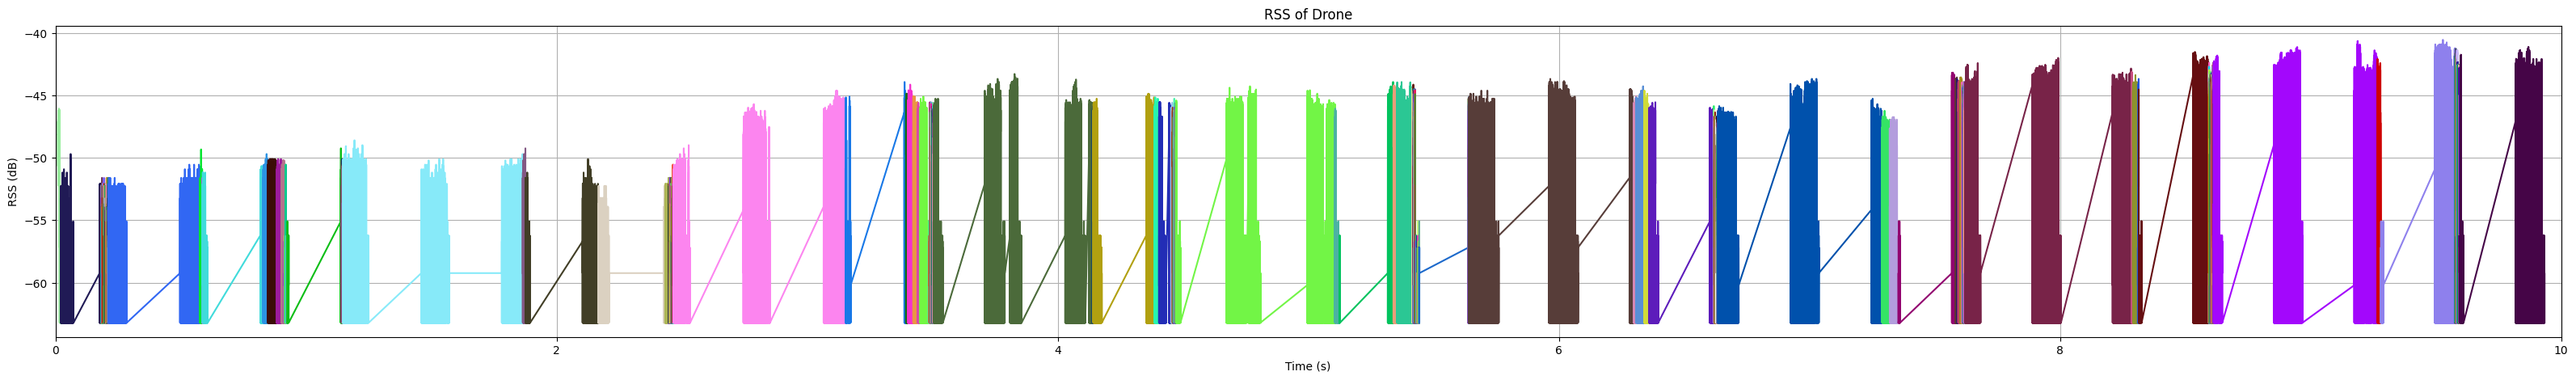

In [12]:
plt.figure(figsize=(40, 5))

# print(len(blocks))
for packet in blocks:
    # print(packet)
    color = (random.random(), random.random(), random.random())
    plt.plot(packet['time'], packet['rss'], color=color)
    

plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

In [35]:
directory = 'datasets/drone1_1m/'  # Replace with the actual directory path
drone1_1m_measurements = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        drone1_1m_measurements[degrees] = data['rss'].mean()
        data = None
        


100%|██████████| 16/16 [03:44<00:00, 14.05s/it]


In [36]:
directory = 'datasets/drone2_1m/'  # Replace with the actual directory path
drone2_1m_measurements = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        drone2_1m_measurements[degrees] = data['rss'].mean()
        data = None
        


100%|██████████| 16/16 [03:30<00:00, 13.13s/it]


In [37]:
directory = 'datasets/drone3_1m/'  # Replace with the actual directory path
drone3_1m_measurements = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        drone3_1m_measurements[degrees] = data['rss'].mean()
        data = None
        


100%|██████████| 16/16 [05:37<00:00, 21.08s/it]


In [32]:
directory = 'datasets/drone1_second_1m/'  # Replace with the actual directory path
drone1_second_1m_measurement = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        drone1_second_1m_measurement[degrees] = data['rss'].mean()
        data = None
        


100%|██████████| 16/16 [03:07<00:00, 11.73s/it]


In [ ]:
directory = 'datasets/drone1_second_1m/'  # Replace with the actual directory path
drone2_second_1m_measurements = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        drone2_second_1m_measurements[degrees] = data['rss'].mean()
        data = None
        


100%|██████████| 16/16 [03:44<00:00, 14.05s/it]


In [ ]:
directory = 'datasets/drone3_1m/'  # Replace with the actual directory path
drone3_second_1m_measurements = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        drone3_second_1m_measurements[degrees] = data['rss'].mean()
        data = None
        


100%|██████████| 16/16 [03:44<00:00, 14.05s/it]


In [39]:
rss_values_radiation_patterns1 = [drone1_1m_measurements, drone2_1m_measurements, drone3_1m_measurements]
# rss_values_radiation_patterns1 = [drone1_second_1m_measurement, drone2_second_1m_measurements, drone3_second_1m_measurements]

16 16
16 16
16 16


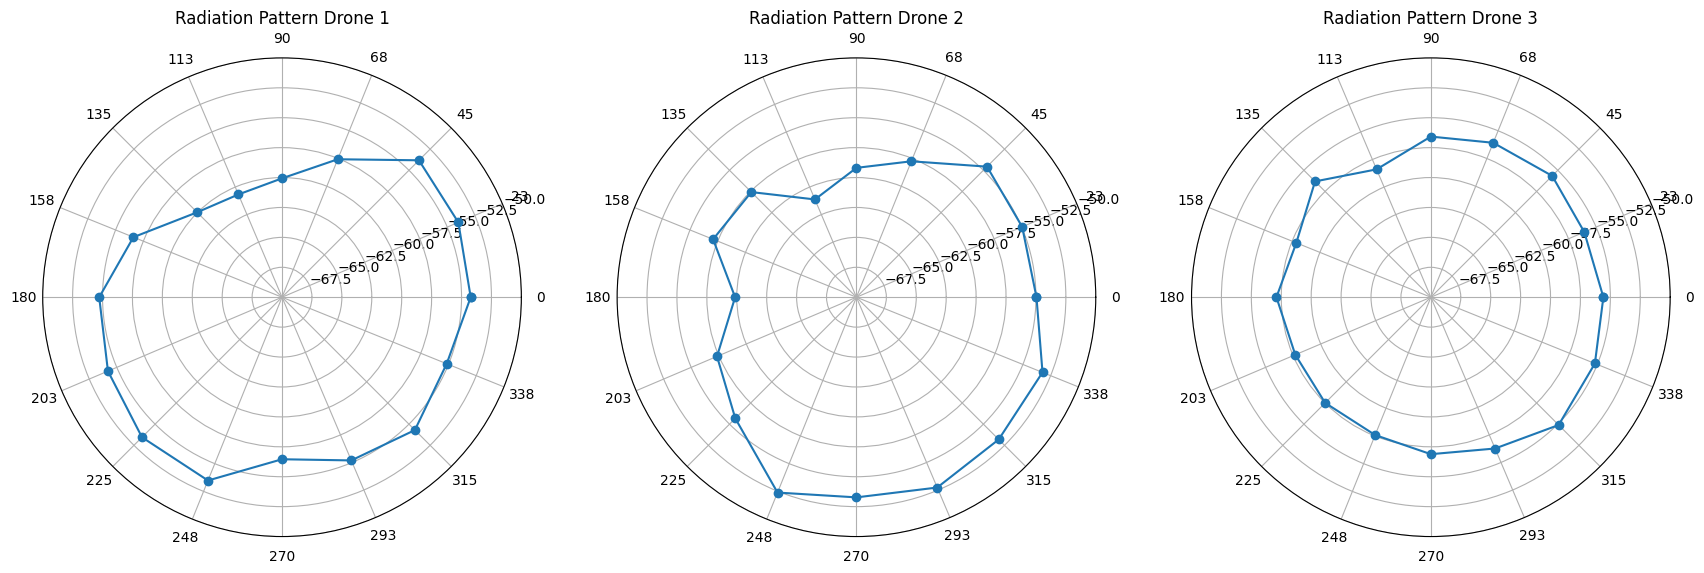

In [40]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(21, 7), subplot_kw={'projection': 'polar'})

for i in range(len(rss_values_radiation_patterns1)):
    create_radiation_pattern(axis[i], rss_values_radiation_patterns1[i], y_limit=(-70, -50), title='Radiation Pattern Drone ' + str(i+1))
plt.show()